<a href="https://colab.research.google.com/github/jeffheaton/present/blob/master/WUSTL/CABI-Demand/demand_multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multivariate Projection

First map Google drive.

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


Load the three data files.

In [ ]:
import pandas as pd
import os

PATH = "/content/drive/MyDrive/projects/demand/"

df_sales = pd.read_csv("https://data.heatonresearch.com/wustl/CABI/demand-forecast/sales_train.csv", parse_dates=['date'])
df_items = pd.read_csv("https://data.heatonresearch.com/wustl/CABI/demand-forecast/items.csv")
df_resturant = pd.read_csv("https://data.heatonresearch.com/wustl/CABI/demand-forecast/resturants.csv")

Utility function to create sequences.

In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Join the items and sales tables so that we can look up the store id for each item.

In [ ]:
df_items2 = df_items[['id','store_id']]
df_train = df_sales.merge(df_items2,left_on='item_id',right_on='id')
df_train[['date','item_id','item_count','store_id']]

df_train = df_train.sort_values('date').groupby(['item_id', 'store_id', 'date'], as_index=False)
df_train = df_train.agg({'item_count':['mean']})
df_train.columns = ['item', 'store', 'date', 'sales']
df_train.head()

,item,store,date,sales
0,1,4,2020-12-01,1.0
1,1,4,2021-10-14,1.0
2,2,4,2020-04-30,1.0
3,2,4,2020-06-09,1.0
4,2,4,2020-12-26,1.0


In [ ]:
df_train['dow'] = df_train['date'].dt.dayofweek
df_train['doy'] = df_train['date'].dt.dayofyear
df_train

,item,store,date,sales,dow,doy
0,1,4,2020-12-01,1.0,1,336
1,1,4,2021-10-14,1.0,3,287
2,2,4,2020-04-30,1.0,3,121
3,2,4,2020-06-09,1.0,1,161
4,2,4,2020-12-26,1.0,5,361
...,...,...,...,...,...,...
15636,100,2,2021-08-10,1.0,1,222
15637,100,2,2021-11-08,1.0,0,312
15638,100,2,2021-11-20,1.0,5,324
15639,100,2,2021-12-03,1.0,4,337


Build the sequence data.

In [ ]:
window = 29
future_span = 30
series = series_to_supervised(df_train.drop('date', axis=1), window=window, lag=future_span)
series.head()

,item(t-29),store(t-29),sales(t-29),dow(t-29),doy(t-29),item(t-28),store(t-28),sales(t-28),dow(t-28),doy(t-28),...,item(t),store(t),sales(t),dow(t),doy(t),item(t+30),store(t+30),sales(t+30),dow(t+30),doy(t+30)
29,1.0,4.0,1.0,1.0,336.0,1.0,4.0,1.0,3.0,287.0,...,3,1,3.0,5,32,3.0,1.0,3.0,3.0,65.0
30,1.0,4.0,1.0,3.0,287.0,2.0,4.0,1.0,3.0,121.0,...,3,1,1.0,6,33,3.0,1.0,1.0,4.0,66.0
31,2.0,4.0,1.0,3.0,121.0,2.0,4.0,1.0,1.0,161.0,...,3,1,1.0,0,34,3.0,1.0,2.0,5.0,67.0
32,2.0,4.0,1.0,1.0,161.0,2.0,4.0,1.0,5.0,361.0,...,3,1,2.0,2,36,3.0,1.0,1.0,6.0,68.0
33,2.0,4.0,1.0,5.0,361.0,2.0,4.0,1.0,4.0,218.0,...,3,1,1.0,3,37,3.0,1.0,1.0,0.0,69.0


Remove sequences that did not have enough data.

In [ ]:
# Remove edge cases, where there were not enough values to complete a series
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
last_dow = 'dow(t-%d)' % window
last_doy = 'doy(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]
#series = series[(series['dow(t)'] == series[last_dow])]
#series = series[(series['doy(t)'] == series[last_doy])]

We will predict with sales, and our engineered features.

In [ ]:
import numpy as np
from keras.utils.np_utils import to_categorical   

def drop_column(df, col):
  columns_to_drop = [('%s(t+%d)' % (col, future_span))]
  for i in range(window, 0, -1):
      columns_to_drop += [('%s(t-%d)' % (col, i))]
  df.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
  df.drop([f"{col}(t)"], axis=1, inplace=True, errors='ignore')

def cat_seq(df, col):
  return to_categorical(df[col].values)

# Label
labels_col = 'sales(t+%d)' % future_span
labels = series[labels_col]
series.drop(labels_col, axis=1, inplace=True)
series.drop('item(t+%d)' % future_span, axis=1, inplace=True)
series.drop('store(t+%d)' % future_span, axis=1, inplace=True)
series.drop('dow(t+%d)' % future_span, axis=1, inplace=True)
series.drop('doy(t+%d)' % future_span, axis=1, inplace=True)

# Get sales sequences
series2 = series.copy()
drop_column(series2, "item")
drop_column(series2, "store")
drop_column(series2, "dow")
drop_column(series2, "doy")
sales_series = series2.values

# Day of week as a categorical
series2 = series.copy()
drop_column(series2, "item")
drop_column(series2, "store")
drop_column(series2, "doy")
drop_column(series2, "sales")
dow_series = series2.values

# Get item sequences
series2 = series.copy()
drop_column(series2, "item")
drop_column(series2, "store")
drop_column(series2, "dow")
drop_column(series2, "sales")
doy_series = series2.values

# Day of year
t1 = sales_series.reshape(sales_series.shape + (1,))
t2 = dow_series.reshape(dow_series.shape + (1,)) 
t3 = doy_series.reshape(doy_series.shape + (1,))
x = np.concatenate([t1,t2,t3],axis=2)

In [ ]:
dow_series = cat_seq(df_train, 'dow')
dow_series.shape

(15641, 7)

In [ ]:
series

,item(t-29),store(t-29),sales(t-29),dow(t-29),doy(t-29),item(t-28),store(t-28),sales(t-28),dow(t-28),doy(t-28),...,item(t-1),store(t-1),sales(t-1),dow(t-1),doy(t-1),item(t),store(t),sales(t),dow(t),doy(t)
35,3.0,1.0,4.0,2.0,1.0,3.0,1.0,1.0,3.0,2.0,...,3.0,1.0,3.0,4.0,38.0,3,1,1.0,5,39
36,3.0,1.0,1.0,3.0,2.0,3.0,1.0,3.0,4.0,3.0,...,3.0,1.0,1.0,5.0,39.0,3,1,1.0,6,40
37,3.0,1.0,3.0,4.0,3.0,3.0,1.0,3.0,5.0,4.0,...,3.0,1.0,1.0,6.0,40.0,3,1,3.0,0,41
38,3.0,1.0,3.0,5.0,4.0,3.0,1.0,2.0,0.0,6.0,...,3.0,1.0,3.0,0.0,41.0,3,1,1.0,1,42
39,3.0,1.0,2.0,0.0,6.0,3.0,1.0,1.0,1.0,7.0,...,3.0,1.0,1.0,1.0,42.0,3,1,2.0,2,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15606,97.0,4.0,1.0,4.0,148.0,97.0,4.0,1.0,6.0,157.0,...,97.0,4.0,1.0,4.0,344.0,97,4,1.0,1,348
15607,97.0,4.0,1.0,6.0,157.0,97.0,4.0,2.0,1.0,159.0,...,97.0,4.0,1.0,1.0,348.0,97,4,1.0,6,353
15608,97.0,4.0,2.0,1.0,159.0,97.0,4.0,1.0,2.0,174.0,...,97.0,4.0,1.0,6.0,353.0,97,4,1.0,2,356
15609,97.0,4.0,1.0,2.0,174.0,97.0,4.0,1.0,4.0,176.0,...,97.0,4.0,1.0,2.0,356.0,97,4,1.0,1,362


In [ ]:
print(t1.shape)
print(t2.shape)
print(t3.shape)

(13813, 30, 1)
(13813, 30, 1)
(13813, 30, 1)


In [ ]:
#store_series = to_categorical(series['store(t)'].values)
#store_series.shape

Extract the predictors (x sequences) and the label (future prediction)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(x, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
#X_train.head()

Train set shape (8287, 30, 3)
Validation set shape (5526, 30, 3)


Final preparation for the x and y.

In [ ]:
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)

Train set shape (8287, 30, 3)
Validation set shape (5526, 30, 3)


Construct the neural network.

In [ ]:
import tensorflow as tf 
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
import keras

epochs = 500
batch = 256
lr = 0.0003
adam = tf.keras.optimizers.Adam(lr)

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=8, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer=adam)
model.summary()

#model = Sequential()
#model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dense(1))
#model.compile(loss='mse', optimizer=adam)
#model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 64)            1600      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 50)                16050     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                        

Fit the neural network.

In [ ]:
from keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)

cnn_history = model.fit(X_train, Y_train, callbacks=[monitor],
    validation_data=(X_valid, Y_valid), epochs=epochs, verbose=2)

Epoch 1/500
259/259 - 4s - loss: 836.5165 - val_loss: 297.8695 - 4s/epoch - 16ms/step
Epoch 2/500
259/259 - 1s - loss: 322.0128 - val_loss: 203.7074 - 798ms/epoch - 3ms/step
Epoch 3/500
259/259 - 1s - loss: 265.6661 - val_loss: 168.8148 - 800ms/epoch - 3ms/step
Epoch 4/500
259/259 - 1s - loss: 244.9824 - val_loss: 169.5669 - 780ms/epoch - 3ms/step
Epoch 5/500
259/259 - 1s - loss: 233.4389 - val_loss: 177.0822 - 784ms/epoch - 3ms/step
Epoch 6/500
259/259 - 1s - loss: 214.3590 - val_loss: 143.1815 - 762ms/epoch - 3ms/step
Epoch 7/500
259/259 - 1s - loss: 211.3273 - val_loss: 155.2563 - 761ms/epoch - 3ms/step
Epoch 8/500
259/259 - 1s - loss: 212.6535 - val_loss: 135.1019 - 767ms/epoch - 3ms/step
Epoch 9/500
259/259 - 1s - loss: 210.0567 - val_loss: 133.0762 - 795ms/epoch - 3ms/step
Epoch 10/500
259/259 - 1s - loss: 207.3924 - val_loss: 141.5475 - 768ms/epoch - 3ms/step
Epoch 11/500
259/259 - 1s - loss: 204.0821 - val_loss: 137.4507 - 758ms/epoch - 3ms/step
Epoch 12/500
259/259 - 1s - loss

Predict and evaluate the validation data.

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

cnn_train_pred = model.predict(X_train)
cnn_valid_pred = model.predict(X_valid)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

Train rmse: 7.447884492904997
Validation rmse: 8.358024863700136


Train rmse: 8.260069977016887
Validation rmse: 10.943058830677673

Plot the training curve.

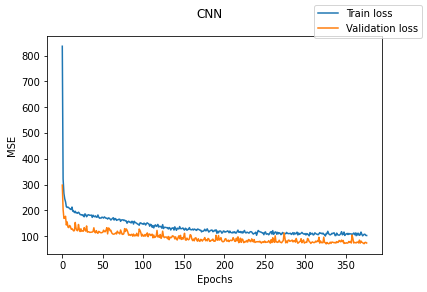

In [ ]:
import matplotlib.pyplot as plt

#fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
#ax1, ax2 = axes[0]
#ax3, ax4 = axes[1]

fig = plt.figure()
plt.plot(cnn_history.history['loss'], label='Train loss')
plt.plot(cnn_history.history['val_loss'], label='Validation loss')
fig.legend()
fig.suptitle('CNN')
plt.xlabel("Epochs")
plt.ylabel("MSE")

plt.show()